In [5]:
import os
import random
import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import pickle
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
np.set_printoptions(suppress=True)
os.chdir('C:/Users/rustem.kamilyanov/trainee/reports/2/rec_models/report2')
#os.chdir('/home/rustem/trainee/reports/2/rec_models/report2/')

### Данные пользователей

In [6]:
df = pd.read_csv('features.csv')
df1 = df.drop(['Unnamed: 0', 'smoking', 'name'], axis=1)
df1.head()

,age,sex,price,time,classes,disability,preferential,job,city,marit_status,education,childs,networks
0,30,М,31039.0,104.0,купе,Нет,Нет,NaN,г. Москва,в браке,NaN,Нет,vk
1,35,Ж,16694.0,58.0,купе,Нет,Нет,Работники сферы индивидуальных услуг,г. Златоуст,NaN,высшее,1,vk
2,76,Ж,21263.0,84.0,плацкарт,Нет,Нет,NaN,г. Тула,NaN,NaN,2,Нет
3,71,М,16374.0,55.0,купе,Нет,Нет,NaN,г. Стерлитамак,в браке,среднее профессиональное,NaN,одноклассники
4,48,Ж,23127.0,88.0,плацкарт,Нет,Нет,Водители и операторы подвижного оборудования,г. Электросталь,в браке,NaN,Нет,Нет


In [7]:
# dummies
df1 = pd.get_dummies(df1, columns=['sex', 'classes', 'disability', 'preferential', 'job',
                            'city', 'marit_status', 'education', 'childs', 'networks'], drop_first = True)

# (Xi - mean) / std
def norm2(array):
    return pd.Series( map( lambda x: (x-array.mean())/array.std(), array ))

# стандартизируем (price, age, time)
df1_norm2 = df1.copy()
for col in df1_norm2.columns[0:3]:
    df1_norm2[col] = norm2(df1_norm2[col])


### Кластеризация kMeans + t-SNE

C:\Users\rustem.kamilyanov\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
C:\Users\rustem.kamilyanov\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


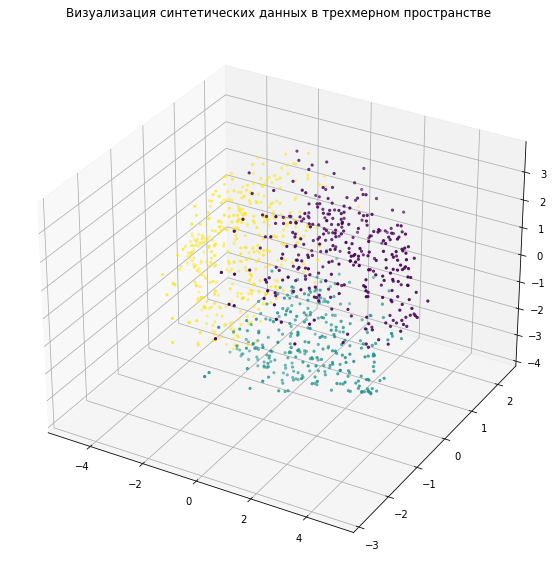

In [29]:
# 3d
metric = 'chebyshev'
learning_rate = 50

m = TSNE(n_components=3, 
         learning_rate=learning_rate, 
         metric=metric,
         random_state=14)
df1_norm2_tsne = m.fit_transform(df1_norm2)
df1_norm2_tsne = pd.DataFrame(df1_norm2_tsne)

# метки на t-SNE пространстве
n=3

m = KMeans(n_clusters=n, random_state=14,
           n_jobs =-1, max_iter=10000, n_init=100)
m.fit(df1_norm2)

df1_norm2_tsne['cluster'] = m.labels_
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df1_norm2_tsne.iloc[:, 1],
           df1_norm2_tsne.iloc[:, 0],
           df1_norm2_tsne.iloc[:, 2],
           s=5,
           c=df1_norm2_tsne['cluster'])
label = 'Визуализация синтетических данных в трехмерном пространстве'
plt.title(label)

# метки
df1['clust'] = m.labels_

### Интерпретация

In [31]:
# средние значения по кластерам
df1_group=pd.read_csv('df1_group.csv')
df1_group = df1_group.set_index('clust')
for a in range(0, 3):
    for i in range(3, len(df1_group.columns)):
        if a == 0:
            df1_group.iloc[a, i] = df1_group.iloc[a, i]/316
        if a == 1:
            df1_group.iloc[a, i] = df1_group.iloc[a, i]/402
        if a == 2:
            df1_group.iloc[a, i] = df1_group.iloc[a, i]/282

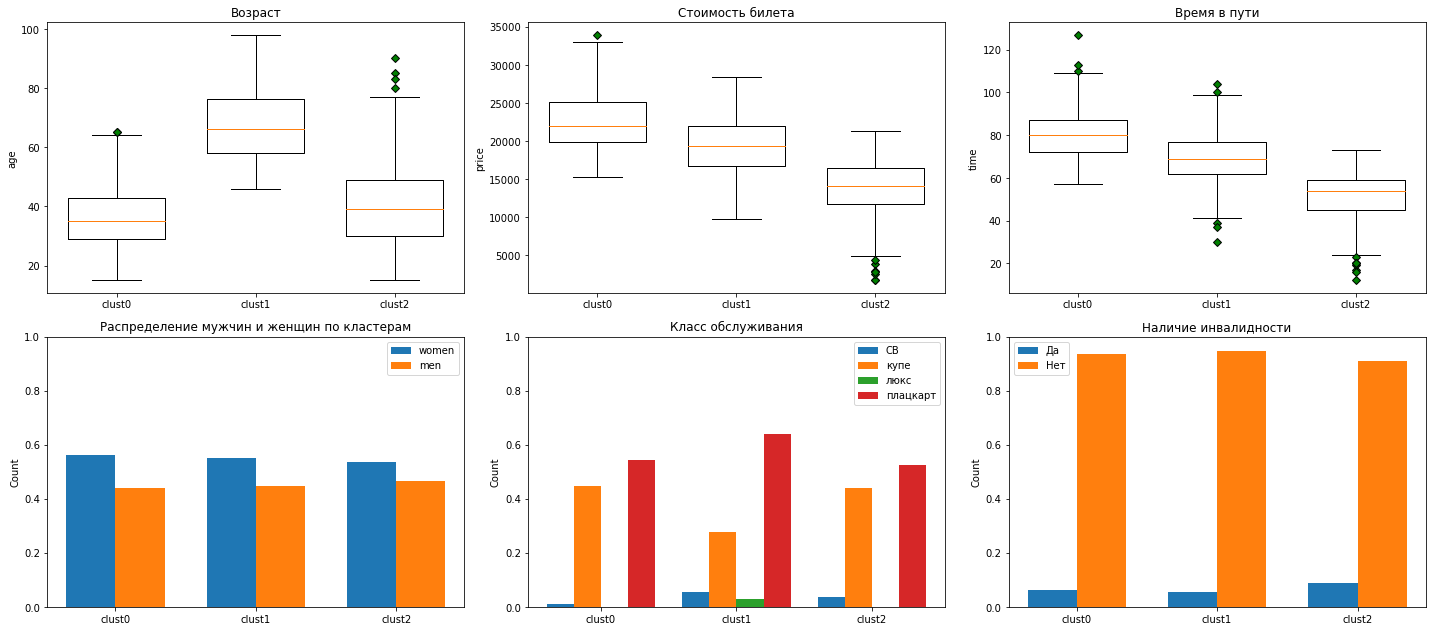

In [32]:
#@title
fig, ax = plt.subplots(figsize=(20,13))
r = 3
c = 3
# ВОЗРАСТ
my_dict = {'clust0':df1['age'][df1['clust']==0], 
           'clust1':df1['age'][df1['clust']==1], 
           'clust2':df1['age'][df1['clust']==2]}

width = 0.7
green_diamond = dict(markerfacecolor='g', marker='D')

ax = plt.subplot(r, c, 1)
ax.boxplot(my_dict.values(), widths=width, flierprops=green_diamond)
ax.set_ylabel('age')
ax.set_xticklabels(my_dict.keys())
ax.set_title('Возраст')
fig.tight_layout()

# ЦЕНА БИЛЕТА
my_dict = {'clust0':df1['price'][df1['clust']==0], 
           'clust1':df1['price'][df1['clust']==1], 
           'clust2':df1['price'][df1['clust']==2]}

width = 0.7
green_diamond = dict(markerfacecolor='g', marker='D')

ax = plt.subplot(r, c, 2)
ax.boxplot(my_dict.values(), widths=width, flierprops=green_diamond)
ax.set_ylabel('price')
ax.set_xticklabels(my_dict.keys())
ax.set_title('Стоимость билета')
fig.tight_layout()

# ВРЕМЯ В ПУТИ
my_dict = {'clust0':df1['time'][df1['clust']==0], 
           'clust1':df1['time'][df1['clust']==1], 
           'clust2':df1['time'][df1['clust']==2]}

width = 0.7
green_diamond = dict(markerfacecolor='g', marker='D')

ax = plt.subplot(r, c, 3)
ax.boxplot(my_dict.values(), widths=width, flierprops=green_diamond)
ax.set_ylabel('time')
ax.set_xticklabels(my_dict.keys())
ax.set_title('Время в пути')
fig.tight_layout()

# РАСПРЕДЕЛЕНИЕ МУЖЧИН И ЖЕНЩИН ПО КЛАСТЕРАМ
labels = ['clust0', 'clust1', 'clust2']
women = [df1_group.loc[0, 'sex_Ж'],
         df1_group.loc[1, 'sex_Ж'],
         df1_group.loc[2, 'sex_Ж']]
men = [df1_group.loc[0, 'sex_М'],
       df1_group.loc[1, 'sex_М'],
       df1_group.loc[2, 'sex_М']]

x = np.arange(len(labels))
width = 0.35


ax = plt.subplot(r, c, 4)
ax.bar(x - width/2, women, width, label='women')
ax.bar(x + width/2, men, width, label='men')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Распределение мужчин и женщин по кластерам')
ax.set_ylim(0, 1)
plt.legend()
fig.tight_layout()

# РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ
labels = ['clust0', 'clust1', 'clust2']
sv = [df1_group.iloc[0, 6],
      df1_group.iloc[1, 6],
      df1_group.iloc[2, 6]]

cupe = [df1_group.iloc[0, 7],
        df1_group.iloc[1, 7],
        df1_group.iloc[2, 7]]

luxe = [df1_group.iloc[0, 8],
        df1_group.iloc[1, 8],
        df1_group.iloc[2, 8]]

plackart = [df1_group.iloc[0, 9],
            df1_group.iloc[1, 9],
            df1_group.iloc[2, 9]] 
        
x = np.arange(len(labels))
width = 0.2


ax = plt.subplot(r, c, 5)
ax.bar(x - width*1.5, sv, width, label='СВ')
ax.bar(x - width/2, cupe, width, label='купe')
ax.bar(x + width/2, luxe, width, label='люкс')
ax.bar(x + width*1.5, plackart, width, label='плацкарт')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Класс обслуживания')
ax.set_ylim(0, 1)
plt.legend()
fig.tight_layout()

# ИНВАЛИДНОСТЬ
labels = ['clust0', 'clust1', 'clust2']
yes = [df1_group.iloc[0, 11],
       df1_group.iloc[1, 11],
       df1_group.iloc[2, 11]]

no = [df1_group.iloc[0, 12],
      df1_group.iloc[1, 12],
      df1_group.iloc[2, 12]]

x = np.arange(len(labels))
width = 0.35


ax = plt.subplot(r, c, 6)
ax.bar(x - width/2, yes, width, label='Да')
ax.bar(x + width/2, no, width, label='Нет')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Наличие инвалидности')
ax.set_ylim(0, 1)
plt.legend()
fig.tight_layout()

# ЛЬГОТНАЯ КАТЕГОРИЯ
labels = ['clust0', 'clust1', 'clust2']
yes = [df1_group.iloc[0, 14],
       df1_group.iloc[1, 14],
       df1_group.iloc[2, 14]]

no = [df1_group.iloc[0, 15],
      df1_group.iloc[1, 15],
      df1_group.iloc[2, 15]]

x = np.arange(len(labels))
width = 0.35


#ax = plt.subplot(r, c, 7)
#ax.bar(x - width/2, yes, width, label='Да')
#ax.bar(x + width/2, no, width, label='Нет')
#ax.set_ylabel('Count')
#ax.set_xticks(x)
#ax.set_xticklabels(labels)
#ax.set_title('Льготная категория')
#ax.set_ylim(0, 1)
#plt.legend()
#fig.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


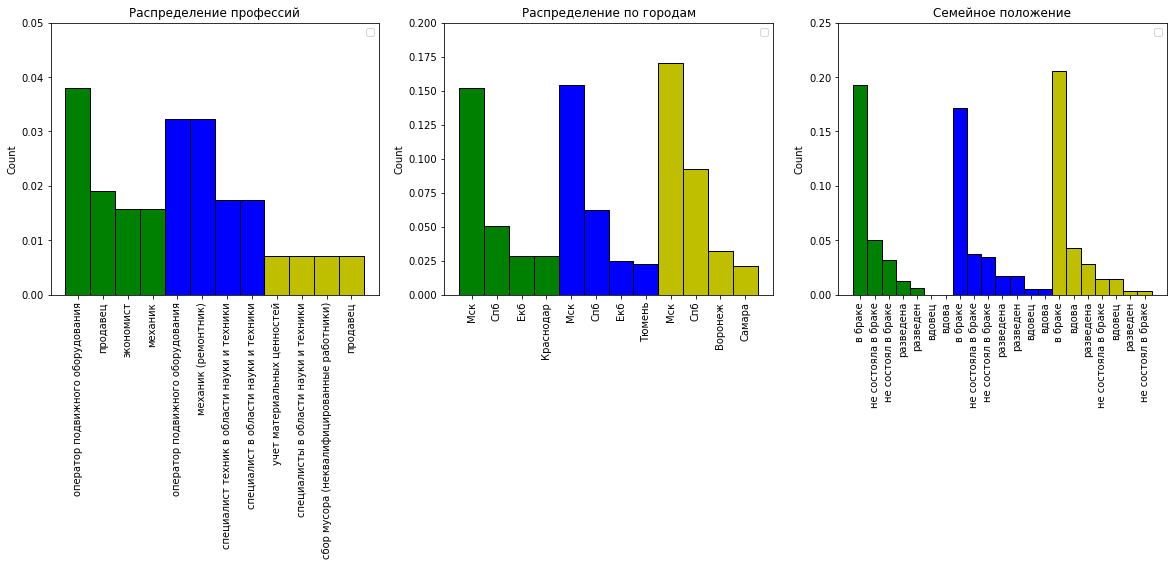

In [7]:
#@title
fig2, ax = plt.subplots(figsize=(20,5))
r = 1
c = 3
# ПРОФЕССИЯ
labels = ['clust0', 'clust1', 'clust2']

top = [df1_group.T.iloc[17:44, 0].sort_values(ascending=False)[0],
       df1_group.T.iloc[17:44, 0].sort_values(ascending=False)[1],
       df1_group.T.iloc[17:44, 0].sort_values(ascending=False)[2],
       df1_group.T.iloc[17:44, 0].sort_values(ascending=False)[3],
       df1_group.T.iloc[17:44, 1].sort_values(ascending=False)[0],
       df1_group.T.iloc[17:44, 1].sort_values(ascending=False)[1],
       df1_group.T.iloc[17:44, 1].sort_values(ascending=False)[2],
       df1_group.T.iloc[17:44, 1].sort_values(ascending=False)[3],
       df1_group.T.iloc[17:44, 2].sort_values(ascending=False)[0],
       df1_group.T.iloc[17:44, 2].sort_values(ascending=False)[1],
       df1_group.T.iloc[17:44, 2].sort_values(ascending=False)[2],
       df1_group.T.iloc[17:44, 2].sort_values(ascending=False)[3]]

x = np.arange(12)
width = 1

ax = plt.subplot(r, c, 1)
ax.bar(x, top, width, color=['g','g','g','g', 
                             'b','b','b','b',
                             'y','y','y','y'], edgecolor='black')

jobs = ['оператор подвижного оборудования', 'продавец', 'экономист',
        'механик', 'оператор подвижного оборудования','механик (ремонтник)',
        'специалист техник в области науки и техники', 'специалист в области науки и техники',
        'учет материальных ценностей', 'специалисты в области науки и техники', 
        'сбор мусора (неквалифицированные работники)', 'продавец']

ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(jobs, rotation=90)
ax.set_title('Распределение профессий')
ax.set_ylim(0, 0.05)
plt.legend()
fig.tight_layout()

# ГОРОД
labels = ['clust0', 'clust1', 'clust2']

top = [df1_group.T.iloc[46:207, 0].sort_values(ascending=False)[0], #Мск
       df1_group.T.iloc[46:207, 0].sort_values(ascending=False)[1], #Спб
       df1_group.T.iloc[46:207, 0].sort_values(ascending=False)[2], #Екб
       df1_group.T.iloc[46:207, 0].sort_values(ascending=False)[3], #Краснодар
       df1_group.T.iloc[46:207, 1].sort_values(ascending=False)[0], #Мск
       df1_group.T.iloc[46:207, 1].sort_values(ascending=False)[1], #Спб
       df1_group.T.iloc[46:207, 1].sort_values(ascending=False)[2], #Екб
       df1_group.T.iloc[46:207, 1].sort_values(ascending=False)[3], #Тюмень
       df1_group.T.iloc[46:207, 2].sort_values(ascending=False)[0], #Мск
       df1_group.T.iloc[46:207, 2].sort_values(ascending=False)[1], #Спб
       df1_group.T.iloc[46:207, 2].sort_values(ascending=False)[2], #Воронеж
       df1_group.T.iloc[46:207, 2].sort_values(ascending=False)[3]] #Самара

city = ['Мск', 'Спб', 'Екб', 'Краснодар', 
        'Мск', 'Спб', 'Екб', 'Тюмень',
        'Мск', 'Спб', 'Воронеж', 'Самара']

x = np.arange(12)
width = 1

ax = plt.subplot(r, c, 2)
ax.bar(x, top, width, color=['g','g','g','g', 
                             'b','b','b','b',
                             'y','y','y','y'], edgecolor='black')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(city, rotation=90)
ax.set_title('Распределение по городам')
ax.set_ylim(0, 0.2)
plt.legend()
fig.tight_layout()

# СЕМЕЙНОЕ ПОЛОЖЕНИЕ
status = [df1_group.T.iloc[207:214, 0].sort_values(ascending=False)[0],
          df1_group.T.iloc[207:214, 0].sort_values(ascending=False)[1],
          df1_group.T.iloc[207:214, 0].sort_values(ascending=False)[2],
          df1_group.T.iloc[207:214, 0].sort_values(ascending=False)[3],
          df1_group.T.iloc[207:214, 0].sort_values(ascending=False)[4],
          df1_group.T.iloc[207:214, 0].sort_values(ascending=False)[5],
          df1_group.T.iloc[207:214, 0].sort_values(ascending=False)[6],
          
          df1_group.T.iloc[207:214, 1].sort_values(ascending=False)[0],
          df1_group.T.iloc[207:214, 1].sort_values(ascending=False)[1],
          df1_group.T.iloc[207:214, 1].sort_values(ascending=False)[2],
          df1_group.T.iloc[207:214, 1].sort_values(ascending=False)[3],
          df1_group.T.iloc[207:214, 1].sort_values(ascending=False)[4],
          df1_group.T.iloc[207:214, 1].sort_values(ascending=False)[5],
          df1_group.T.iloc[207:214, 1].sort_values(ascending=False)[6],
          
          df1_group.T.iloc[207:214, 2].sort_values(ascending=False)[0],
          df1_group.T.iloc[207:214, 2].sort_values(ascending=False)[1],
          df1_group.T.iloc[207:214, 2].sort_values(ascending=False)[2],
          df1_group.T.iloc[207:214, 2].sort_values(ascending=False)[3],
          df1_group.T.iloc[207:214, 2].sort_values(ascending=False)[4],
          df1_group.T.iloc[207:214, 2].sort_values(ascending=False)[5],
          df1_group.T.iloc[207:214, 2].sort_values(ascending=False)[6]]

labels = ['в браке', 'не состояла в браке',
       'не состоял в браке', 'разведена',
       'разведен', 'вдовец', 'вдова',
       'в браке', 'не состояла в браке',
       'не состоял в браке', 'разведена',
       'разведен', 'вдовец', 'вдова',
       'в браке', 'вдова', 'разведена',
       'не состояла в браке', 'вдовец',
       'разведен', 'не состоял в браке']

x = np.arange(21)
width = 1

ax = plt.subplot(r, c, 3)
ax.bar(x, status, width, color=['g','g','g','g','g','g','g', 
                                'b','b','b','b','b','b','b',
                                'y','y','y','y','y','y','y'], edgecolor='black')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_title('Семейное положение')
ax.set_ylim(0, 0.25)
plt.legend()
fig.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


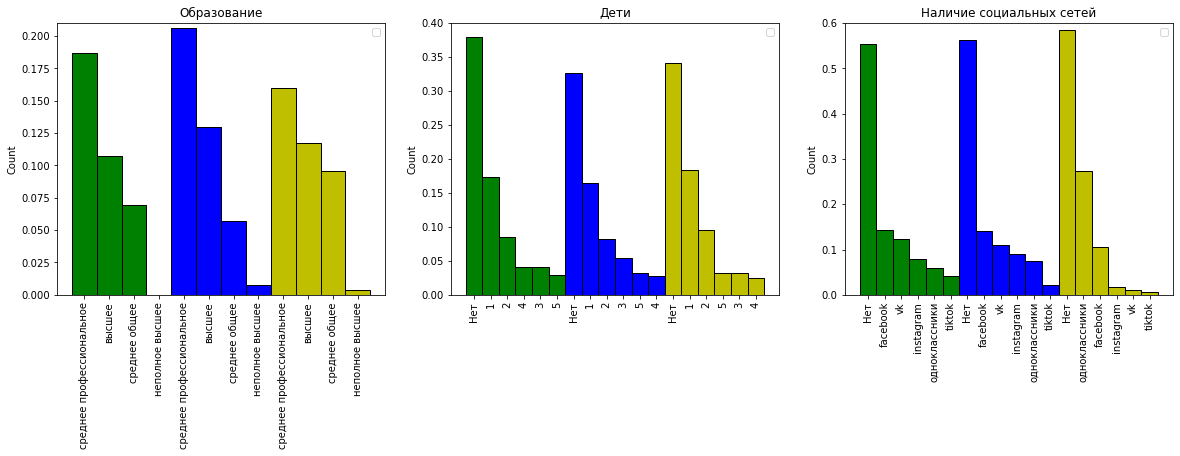

In [8]:
#@title
fig3, ax = plt.subplots(figsize=(20,5))
r = 1
c = 3
# ОБРАЗОВАНИЕ
top = [df1_group.T.iloc[215:219, 0].sort_values(ascending=False)[0],
       df1_group.T.iloc[215:219, 0].sort_values(ascending=False)[1],
       df1_group.T.iloc[215:219, 0].sort_values(ascending=False)[2],
       df1_group.T.iloc[215:219, 0].sort_values(ascending=False)[3],
       df1_group.T.iloc[215:219, 1].sort_values(ascending=False)[0],
       df1_group.T.iloc[215:219, 1].sort_values(ascending=False)[1],
       df1_group.T.iloc[215:219, 1].sort_values(ascending=False)[2],
       df1_group.T.iloc[215:219, 1].sort_values(ascending=False)[3],
       df1_group.T.iloc[215:219, 2].sort_values(ascending=False)[0],
       df1_group.T.iloc[215:219, 2].sort_values(ascending=False)[1],
       df1_group.T.iloc[215:219, 2].sort_values(ascending=False)[2],
       df1_group.T.iloc[215:219, 2].sort_values(ascending=False)[3]]

labels = ['среднее профессиональное', 'высшее',
       'среднее общее', 'неполное высшее',
       'среднее профессиональное', 'высшее',
       'среднее общее', 'неполное высшее',
       'среднее профессиональное', 'высшее',
       'среднее общее', 'неполное высшее']

x = np.arange(12)
width = 1

ax = plt.subplot(r, c, 1)
ax.bar(x, top, width, color=['g','g','g','g', 
                             'b','b','b','b',
                             'y','y','y','y'], edgecolor='black')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_title('Образование')
ax.set_ylim(0, 0.21)
plt.legend()
fig.tight_layout()

# ДЕТИ
top = [df1_group.T.iloc[220:226, 0].sort_values(ascending=False)[0],
       df1_group.T.iloc[220:226, 0].sort_values(ascending=False)[1],
       df1_group.T.iloc[220:226, 0].sort_values(ascending=False)[2],
       df1_group.T.iloc[220:226, 0].sort_values(ascending=False)[3],
       df1_group.T.iloc[220:226, 0].sort_values(ascending=False)[4],
       df1_group.T.iloc[220:226, 0].sort_values(ascending=False)[5],

       df1_group.T.iloc[220:226, 1].sort_values(ascending=False)[0],
       df1_group.T.iloc[220:226, 1].sort_values(ascending=False)[1],
       df1_group.T.iloc[220:226, 1].sort_values(ascending=False)[2],
       df1_group.T.iloc[220:226, 1].sort_values(ascending=False)[3],
       df1_group.T.iloc[220:226, 1].sort_values(ascending=False)[4],
       df1_group.T.iloc[220:226, 1].sort_values(ascending=False)[5],

       df1_group.T.iloc[220:226, 2].sort_values(ascending=False)[0],
       df1_group.T.iloc[220:226, 2].sort_values(ascending=False)[1],
       df1_group.T.iloc[220:226, 2].sort_values(ascending=False)[2],
       df1_group.T.iloc[220:226, 2].sort_values(ascending=False)[3],
       df1_group.T.iloc[220:226, 2].sort_values(ascending=False)[4],
       df1_group.T.iloc[220:226, 2].sort_values(ascending=False)[5]]

labels = ['Нет', '1', '2', '4', '3', '5',
          'Нет', '1', '2', '3', '5', '4',
          'Нет', '1', '2', '5', '3', '4']

x = np.arange(18)
width = 1

ax = plt.subplot(r, c, 2)
ax.bar(x, top, width, color=['g','g','g','g','g','g', 
                             'b','b','b','b','b','b',
                             'y','y','y','y','y','y'], edgecolor='black')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_title('Дети')
ax.set_ylim(0, 0.4)
plt.legend()
fig.tight_layout()

# СОЦ.СЕТИ
top = [df1_group.T.iloc[227:233, 0].sort_values(ascending=False)[0],
       df1_group.T.iloc[227:233, 0].sort_values(ascending=False)[1],
       df1_group.T.iloc[227:233, 0].sort_values(ascending=False)[2],
       df1_group.T.iloc[227:233, 0].sort_values(ascending=False)[3],
       df1_group.T.iloc[227:233, 0].sort_values(ascending=False)[4],
       df1_group.T.iloc[227:233, 0].sort_values(ascending=False)[5],

       df1_group.T.iloc[227:233, 1].sort_values(ascending=False)[0],
       df1_group.T.iloc[227:233, 1].sort_values(ascending=False)[1],
       df1_group.T.iloc[227:233, 1].sort_values(ascending=False)[2],
       df1_group.T.iloc[227:233, 1].sort_values(ascending=False)[3],
       df1_group.T.iloc[227:233, 1].sort_values(ascending=False)[4],
       df1_group.T.iloc[227:233, 1].sort_values(ascending=False)[5],

       df1_group.T.iloc[227:233, 2].sort_values(ascending=False)[0],
       df1_group.T.iloc[227:233, 2].sort_values(ascending=False)[1],
       df1_group.T.iloc[227:233, 2].sort_values(ascending=False)[2],
       df1_group.T.iloc[227:233, 2].sort_values(ascending=False)[3],
       df1_group.T.iloc[227:233, 2].sort_values(ascending=False)[4],
       df1_group.T.iloc[227:233, 2].sort_values(ascending=False)[5]]

labels = ['Нет', 'facebook', 'vk',
       'instagram', 'одноклассники', 'tiktok',
       'Нет', 'facebook', 'vk',
       'instagram', 'одноклассники', 'tiktok',
       'Нет', 'одноклассники', 'facebook',
       'instagram', 'vk', 'tiktok']

x = np.arange(18)
width = 1

ax = plt.subplot(r, c, 3)
ax.bar(x, top, width, color=['g','g','g','g','g','g', 
                             'b','b','b','b','b','b',
                             'y','y','y','y','y','y'], edgecolor='black')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_title('Наличие социальных сетей')
ax.set_ylim(0, 0.6)
plt.legend()
fig.tight_layout()

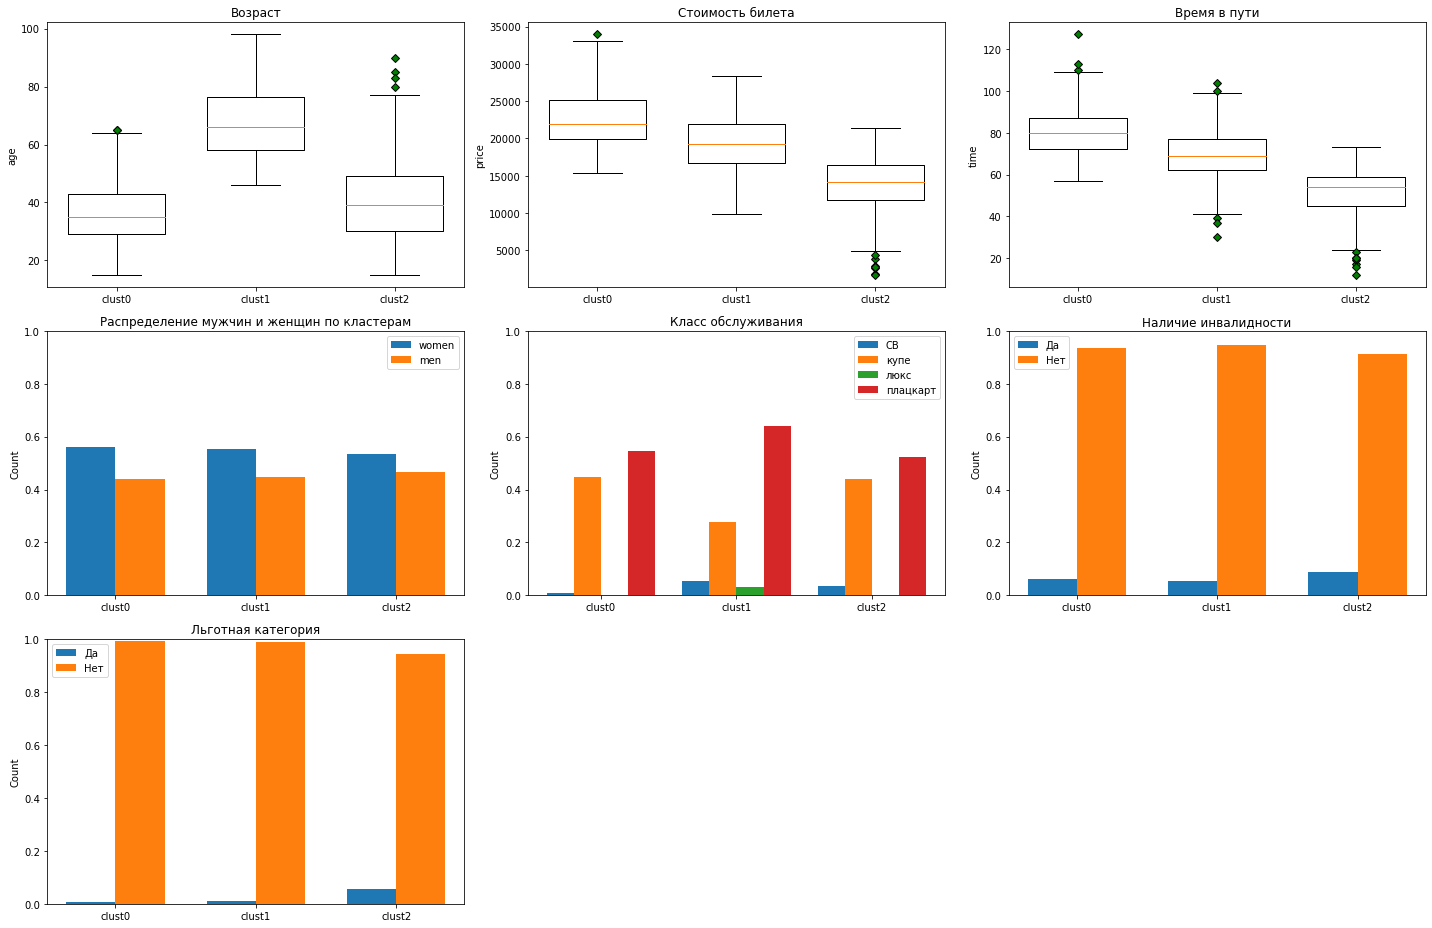

In [9]:
fig

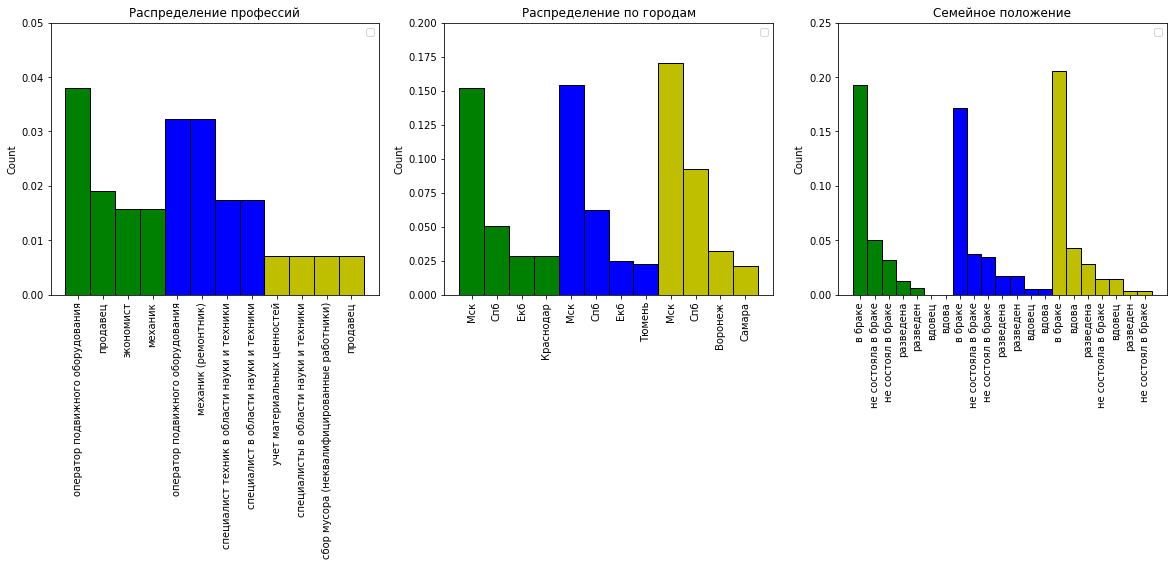

In [10]:
fig2

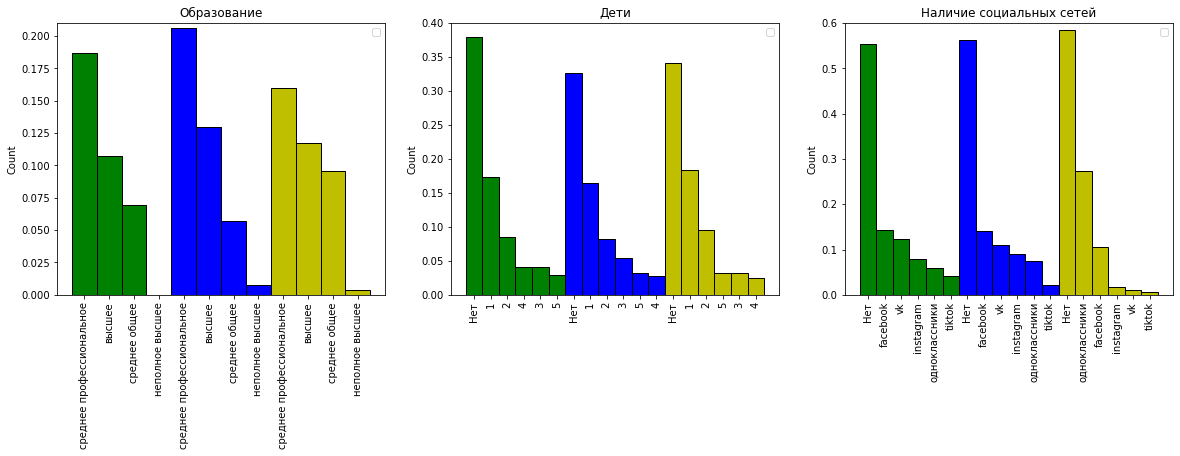

In [11]:
fig3

### Портрет среднестатистического пассажира из кластера - 0:
Средний возраст 36 лет - самый молодой кластер пассажиров.   
Путешествует преимущественно на дальние расстояния, как следствие имеет самую высокую среднюю стоимость билета.  
Пользуется преимущественно недорогим классом обслуживания (плацкарт, купе).  
По профессии является либо рабочим на производстве (оператор подвижного состава, механик), либо имеет профессию низкой квалифифкации (продавец), реже профессию в экономической сфере (экономист).  
Проживает в городе миллионнике (Мск, Спб, Екб), либо в крупном мегаполисе (Краснодар).  
Семейное положение - либо в браке, либо никогда не состаял в браке.  
Преимущественно имеет среднее профессионльное образование, реже - высшее.  
Детей как правило нет, реже 1-2 или 4.  
В соц.сетях не зарегисрирован, либо зарегистрирован в facebook, реже в vkontakte, instagram, крайне редко в одноклассники и tiktok.

### Портрет среднестатистического пассажира из кластера - 1:
Средний возраст 40 лет - средний по возрасту кластер пассажиров.   
Путешествует преимущественно на коротки расстояния, -> имеет самую низкую стоимость билета.  
Пользуется преимущественно недорогим классом обслуживания (плацкарт, купе), так же крайне редко классом СВ и люкс.    
По профессии является специалистом в сфере науки и техники, либо рабочим на производстве (оператор подвижного состава, механик).    
Проживает в городе миллионнике (Мск, Спб, Екб), либо в крупном мегаполисе (Тюмень).  
Семейное положение - либо в браке, либо никогда не состаял в браке.  
Преимущественно имеет среднее профессионльное образование, реже - высшее.  
Детей как правило нет, реже 1-2 или 3.  
В соц.сетях не зарегисрирован, либо зарегистрирован в facebook, реже в vkontakte, instagram, одноклассники, крайне редко в tiktok.

### Портрет среднестатистического пассажира из кластера - 2:
Средний возраст 67 лет - самый возрастной кластер пассажиров.   
Путешествует преимущественно на средние расстояния, -> имеет среднюю стоимость билета.  
Пользуется преимущественно недорогим классом обслуживания (плацкарт, купе), так же крайне редко классом СВ.    
Как правило имеет низкоквалифицированную профессию, либо пенсионер.      
Проживает в городе миллионнике (Мск, Спб), либо в относительно некрупных городах (Воронеж, Самара).  
Семейное положение - либо в браке, либо вдова, реже разведена.  
Преимущественно имеет среднее профессионльное образование, реже - высшее.  
Детей как правило нет, реже 1-2 или 5.  
В соц.сетях не зарегисрирован, либо зарегистрирован в одноклассниках, реже в facebook, крайне редко - instagram, vkontakte, tiktok.

# Рекомендация @5 по кластеру

### Данные пользователей

In [33]:
df = pd.read_csv('features.csv')
df1 = df.drop(['Unnamed: 0', 'smoking', 'name'], axis=1)
df1.head()

,age,sex,price,time,classes,disability,preferential,job,city,marit_status,education,childs,networks
0,30,М,31039.0,104.0,купе,Нет,Нет,NaN,г. Москва,в браке,NaN,Нет,vk
1,35,Ж,16694.0,58.0,купе,Нет,Нет,Работники сферы индивидуальных услуг,г. Златоуст,NaN,высшее,1,vk
2,76,Ж,21263.0,84.0,плацкарт,Нет,Нет,NaN,г. Тула,NaN,NaN,2,Нет
3,71,М,16374.0,55.0,купе,Нет,Нет,NaN,г. Стерлитамак,в браке,среднее профессиональное,NaN,одноклассники
4,48,Ж,23127.0,88.0,плацкарт,Нет,Нет,Водители и операторы подвижного оборудования,г. Электросталь,в браке,NaN,Нет,Нет


### Матрица User-Item

In [34]:
user_item = pd.read_csv('user_items.csv', index_col='user_id')
user_item = user_item.drop(['age', 'childs'], axis=1)      
user_item['clust'] = None
user_item.head()

,clust,powerbank,wi-fi,альбомы,аптечка,аренда планшета,багажный ремень с весами,бутылочки,вагон 3D-cinema,вагон VR-zone,...,сувениры,сумка для документов,сумка поясная,термос,фломастеры,чехол для чемодана,ширма от надоедливого соседа,комплект для пеленания,массажер для шеи,массажер для ног
user_id,,,,,,,,,,,,,,,,,,,,,
0,None,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,None,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
2,None,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0
3,None,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,None,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [35]:
class Clust_top:

      def __init__(self, user_item, df1_norm2):
          self.user_item = user_item
          self.users = df1_norm2

          self.train, self.test = train_test_split(self.users, test_size=0.2, random_state=14)
          self.model = KMeans(n_clusters=3, random_state=14,
                              n_jobs =-1, max_iter=10000, n_init=100)
          self.model.fit(self.train)        

      def predict(self, user, top_k=5):
        id_new = user.name
        self.user_item['clust'].iloc[self.train.index] = self.model.labels_
        clust_label = self.model.predict(np.array(user).reshape(1, -1))
        predict = list(self.user_item.groupby('clust').agg('mean').iloc[clust_label, :].T.sort_values(by=clust_label[0], ascending=False)[0:top_k].index)
        
        # Расстояния до центров кластеров
        c0 = self.model.cluster_centers_[0]
        c1 = self.model.cluster_centers_[1]
        c2 = self.model.cluster_centers_[2]
        print(' Расстояние до центра кластера 0: ', distance.euclidean(c0, user), '\n',
              'Расстояние до центра кластера 1: ', distance.euclidean(c1, user), '\n',
              'Расстояние до центра кластера 2: ', distance.euclidean(c2, user), '\n',
              '\n',
              'Отнесен к кластеру: ', clust_label[0], '\n',
              '\n',
              " Топ "+str(top_k)+" товаров/услуг по кластеру "+str(clust_label[0])+": " + '\n',
              predict)


In [36]:
train, test = train_test_split(df1_norm2, test_size=0.2, random_state=14)
new_user = test.iloc[random.randint(0, 100)]

model = Clust_top(user_item, df1_norm2)
model.predict(new_user)

C:\Users\rustem.kamilyanov\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


 Расстояние до центра кластера 0:  3.76823841774272 
 Расстояние до центра кластера 1:  2.9770890896781492 
 Расстояние до центра кластера 2:  2.5001374330511714 
 
 Отнесен к кластеру:  2 
 
  Топ 5 товаров/услуг по кластеру 2: 
 [' дорожный набор емкостей для косметики', ' влажные салфетки', 'массажер для шеи', ' сувениры', ' питание на выбор']


In [37]:
def hit(actual_items, pred_items):
    hits =[]
    for h in pred_items:
        if h in actual_items:
            hits.append(1)
        else:
            hits.append(0)
    return np.mean(hits)

In [38]:
# модель
m = KMeans(n_clusters=3, random_state=14,
           n_jobs =-1, max_iter=10000, n_init=100)
m.fit(train)

# присваиваем метки для train
user_item['clust'].iloc[train.index] = m.labels_

top_k = 10
metric = []
for i in range(len(test)):
    actual = []
    id_user = test.iloc[i, :].name
    clust_label = m.predict(np.array(test.iloc[i, :]).reshape(1, -1))
    predict = list(user_item.groupby('clust').agg('mean').iloc[clust_label, :].T.sort_values(by=clust_label[0], ascending=False)[0:top_k].index)

    for item in user_item.columns:
        if (user_item[user_item.index == id_user].loc[:, item] > 0).bool():
            actual.append(item)
    metric.append(hit(actual, predict))

C:\Users\rustem.kamilyanov\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [39]:
print('HR@5: ', np.mean(metric))

HR@5:  0.20450000000000002


# ALS разложение User-Item

In [40]:
user_item = pd.read_csv('user_items.csv', index_col='user_id')
user_item = user_item.drop(['age', 'childs', 'clust'], axis=1)
user_item.head()

,powerbank,wi-fi,альбомы,аптечка,аренда планшета,багажный ремень с весами,бутылочки,вагон 3D-cinema,вагон VR-zone,вагон lounge-bar,...,сувениры,сумка для документов,сумка поясная,термос,фломастеры,чехол для чемодана,ширма от надоедливого соседа,комплект для пеленания,массажер для шеи,массажер для ног
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [41]:
class ALS_rec:
    def __init__(self, user_item):
        self.train, self.test = train_test_split(user_item, test_size=0.2, random_state=14)

        self.train_csr = csr_matrix(self.train).tocsr()
        self.test_csr = csr_matrix(self.test).tocsr()

        self.model = AlternatingLeastSquares(factors = 10, iterations = 8, use_gpu=False, )
        self.model.fit(self.train_csr.T)
    
    def predict(self, user, top_k=5):
        rec = self.model.recommend(0, user, N=top_k, filter_already_liked_items=False)
        predict = list( map(lambda x: x[0], rec) )
        recs = list(user_item.columns[predict])
        return print(recs)
        


In [42]:
train, test = train_test_split(user_item, test_size=0.2, random_state=14)
model = ALS_rec(user_item)
model.predict(test.iloc[random.randint(0, 100)])

  0%|          | 0/8 [00:00<?, ?it/s]

[' аптечка', ' wi-fi', ' набор для чистки обуви', 'массажер для ног', ' аренда планшета']


In [43]:
user_item = pd.read_csv('user_items.csv', index_col='user_id')
user_item = user_item.drop(['age', 'childs', 'clust'], axis=1)

train, test = train_test_split(user_item, test_size=0.2)

# преобразуем данные
train_csr = csr_matrix(train.values).tocsr()
test_csr = csr_matrix(test.values).tocsr()

# учим модель
m_als = AlternatingLeastSquares(factors = 10,
                               iterations = 8,
                                use_gpu=False)
m_als.fit(train_csr.T)

# считаем метрику
top_k = 10
metric = []

for i in range(test.shape[0]):
    actual = []
    id_user = test.iloc[i, :].name
    rec = m_als.recommend(0, 
                          test_csr[i], 
                          N=top_k, 
                          filter_already_liked_items=False)
    predict = list( map(lambda x: x[0], rec) )

    for item_id in range(len(user_item.columns)):
        if (user_item[user_item.index == id_user].iloc[:, item_id] > 0).bool():
            actual.append(item_id)
    metric.append(hit(actual, predict))

  0%|          | 0/8 [00:00<?, ?it/s]

In [44]:
print('HR@5: ', np.mean(metric))

HR@5:  0.18400000000000002


# Neural Matrix Factorization

In [45]:
user_item = pd.read_csv('user_items.csv', index_col='user_id')
user_item = user_item.drop(['age', 'childs'], axis=1)
user_item.head()

,clust,powerbank,wi-fi,альбомы,аптечка,аренда планшета,багажный ремень с весами,бутылочки,вагон 3D-cinema,вагон VR-zone,...,сувениры,сумка для документов,сумка поясная,термос,фломастеры,чехол для чемодана,ширма от надоедливого соседа,комплект для пеленания,массажер для шеи,массажер для ног
user_id,,,,,,,,,,,,,,,,,,,,,
0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0
3,2,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Evaluating

In [46]:
def hit(actual_items, pred_items):
    hits =[]
    for h in pred_items:
        if h in actual_items:
            hits.append(1)
        else:
            hits.append(0)
    return np.mean(hits)

@torch.no_grad()
def metrics(model, test_loader, top_k, device):
    _hr = []

    for user, item, label in test_loader:

        user=user.to(device)
        item=item.to(device)  

        predictions = model(user, item)
        predictions = predictions.view(-1)
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(item, indices).cpu().numpy().tolist()
        
        actual = []
        for m in range(len(item)):
            if label[m] == 1:
                actual.append(item[m].item())
            else:
                pass
         
        _hr.append(hit(actual, recommends))

    return np.mean(_hr)

In [47]:
from torch.utils.data import Dataset
class UserItemRatingDatset(Dataset):
    def __init__(self, user_list, item_list, interaction):
        super(UserItemRatingDatset, self).__init__()
        self.user_tensor = torch.tensor(user_list, dtype=torch.long)
        self.item_tensor = torch.tensor(item_list, dtype=torch.long)
        self.interaction_tensor = torch.tensor(interaction, dtype=torch.float)
    
    def __len__(self):
        return len(self.interaction_tensor)
    
    def __getitem__(self, idx):
        return self.user_tensor[idx], self.item_tensor[idx], self.interaction_tensor[idx]


In [48]:
from torch.utils.data import DataLoader

class NCFData(object):

    def __init__(self, user_item, batch_size):
        
        self.batch_size = batch_size
        self.train, self.test = train_test_split(user_item, test_size=0.2, 
                                                 random_state=14)


    def get_train(self):
        users, items, interaction = [], [], []

        for u in range(len(self.train.index)):
            for i in range(len(self.train.columns)):
                users.append(self.train.iloc[u, :].name)
                items.append(i)
                interaction.append(1 if self.train.iloc[u, i] > 0 else 0)
        
        dataset = UserItemRatingDatset(user_list=users, 
                                       item_list=items, 
                                       interaction=interaction)
        return DataLoader(dataset, batch_size=self.batch_size, 
                          shuffle=True)

    def get_test(self):
        users, items, interaction = [], [], []

        for u in range(len(self.test.index)):
            for i in range(len(self.test.columns)):
                users.append(self.test.iloc[u, :].name)
                items.append(i)
                interaction.append(1 if self.test.iloc[u, i] > 0 else 0)
        
        dataset = UserItemRatingDatset(user_list=users, 
                                       item_list=items, 
                                       interaction=interaction)
        return DataLoader(dataset, batch_size=self.batch_size, 
                          shuffle=False)        

In [49]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, layers, dropout_rate):
        super(NeuMF, self).__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.layers = layers
        self.dropout = dropout_rate

        #mf part
        self.embedding_user_mf = nn.Embedding(num_embeddings=self.num_users, 
                                              embedding_dim=self.embedding_dim)
        self.embedding_item_mf = nn.Embedding(num_embeddings=self.num_items, 
                                              embedding_dim=self.embedding_dim)
        
        #mlp part
        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, 
                                               embedding_dim=self.embedding_dim)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, 
                                               embedding_dim=self.embedding_dim)
        
        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.logits = nn.Linear(in_features=self.layers[-1] + self.embedding_dim, out_features=1)
        self.sigmoid = nn.Sigmoid()
        self.mf_linear = nn.Linear(self.embedding_dim, self.embedding_dim)

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        #### mf part
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)
        mf_vector = self.mf_linear(mf_vector)
        mf_vector = self.mf_linear(mf_vector)
        mf_vector = torch.nn.Dropout(p=self.dropout)(mf_vector)

        #### mlp part        
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        
        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)
        mlp_vector = torch.nn.Dropout(p=self.dropout)(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.logits(vector)
        output = self.sigmoid(logits)
        return output

In [50]:
def train_pipeline(model, optimizer, criterion, data, num_epochs):
    loss_history = []
    metric_history = {'HR@5': []}
    test_loader = data.get_test()

    for epoch in range(1, num_epochs+1):
        model.train()

        train_loader = data.get_train()

        for user, item, label in tqdm.tqdm(train_loader, desc=f'[Epoch #{epoch}]',
                                           total=len(train_loader)):
            user = user.to(DEVICE)
            item = item.to(DEVICE)
            label = label.to(DEVICE)

            optimizer.zero_grad()
            prediction = model(user, item)

            loss = criterion(prediction.view(-1), label.view(-1))
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
        
        # Eval
        model.eval()
        hr_i = metrics(model=model, 
                       test_loader=test_loader, 
                       top_k=TOP_K, 
                       device=DEVICE)
        metric_history['HR@5'].append(hr_i)

        print(f'[Epoch #{epoch}] HR: {hr_i:.3f}')
    
    return loss_history, metric_history

In [51]:
# params 

TOP_K = 5
num_epoch = 50
num_users = len(user_item)
num_items = len(user_item.columns)
embedding_dim = 32
layers = [embedding_dim*2, 32, 32, 1]
dropout = 0
batch_size=104
DEVICE='cpu'

data = NCFData(user_item=user_item, batch_size=batch_size)

model = NeuMF(num_users=num_users,
            num_items=num_items,
            embedding_dim=embedding_dim,
            layers=layers,
            dropout_rate=dropout)
model = model.to(DEVICE)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

loss_history, metric_history = train_pipeline(model=model,
                                              optimizer=optimizer,
                                              criterion=criterion,
                                              data=data,
                                              num_epochs = num_epoch)

[Epoch #1]: 100%|███████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 334.86it/s]


[Epoch #1] HR: 0.316


[Epoch #2]: 100%|███████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 348.09it/s]


[Epoch #2] HR: 0.314


[Epoch #3]: 100%|███████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 348.15it/s]


[Epoch #3] HR: 0.312


[Epoch #4]: 100%|███████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 347.57it/s]


[Epoch #4] HR: 0.312


[Epoch #5]: 100%|███████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 341.56it/s]


[Epoch #5] HR: 0.292


[Epoch #6]: 100%|███████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 323.59it/s]


[Epoch #6] HR: 0.294


[Epoch #7]: 100%|███████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 312.05it/s]


[Epoch #7] HR: 0.288


[Epoch #8]: 100%|███████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 305.64it/s]


[Epoch #8] HR: 0.286


[Epoch #9]: 100%|███████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 293.76it/s]


[Epoch #9] HR: 0.300


[Epoch #10]: 100%|██████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 290.00it/s]


[Epoch #10] HR: 0.292


[Epoch #11]: 100%|██████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 283.19it/s]


[Epoch #11] HR: 0.298


[Epoch #12]: 100%|██████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 277.60it/s]


[Epoch #12] HR: 0.304


[Epoch #13]: 100%|██████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 277.99it/s]


[Epoch #13] HR: 0.312


[Epoch #14]: 100%|██████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 248.28it/s]


[Epoch #14] HR: 0.302


[Epoch #15]: 100%|██████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 272.03it/s]


[Epoch #15] HR: 0.302


[Epoch #16]: 100%|██████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 272.09it/s]


[Epoch #16] HR: 0.302


[Epoch #17]: 100%|██████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 269.99it/s]


[Epoch #17] HR: 0.306


[Epoch #18]: 100%|██████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 269.59it/s]


[Epoch #18] HR: 0.302


[Epoch #19]: 100%|██████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 270.64it/s]


[Epoch #19] HR: 0.304


[Epoch #20]: 100%|██████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 272.01it/s]


[Epoch #20] HR: 0.312


KeyboardInterrupt: 

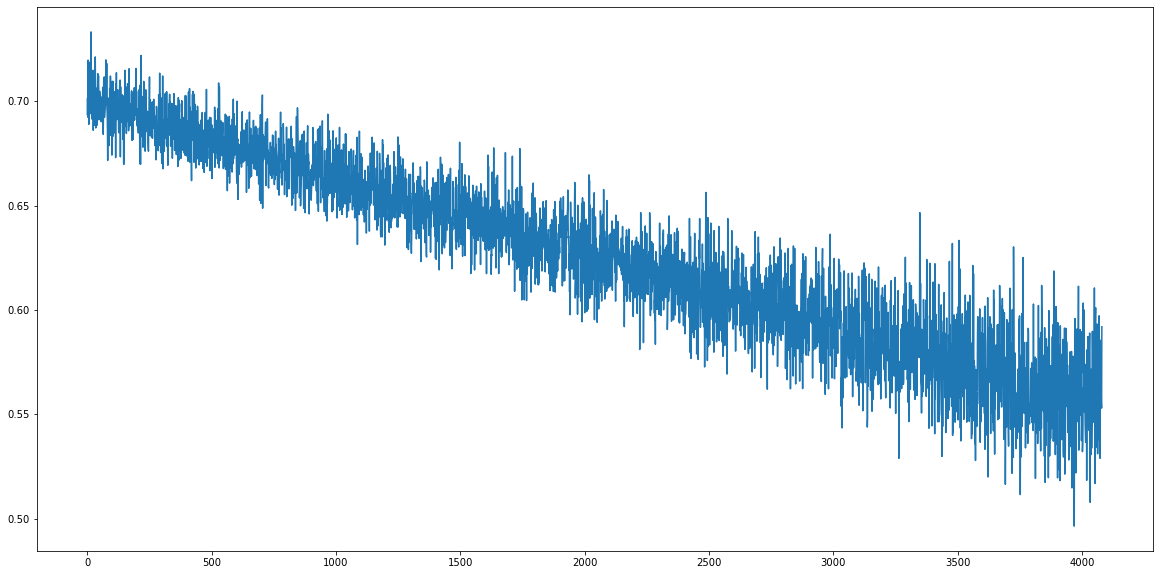

In [31]:
plt.figure(figsize=(20,10))
plt.plot(loss_history)